<a href="https://colab.research.google.com/github/ainsleyyjongg/dl_intro/blob/main/dl_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What you will learn in this notebook

1. Introduction to supervised learning and classification
1. Introduction to loss functions, activation functions, and gradient descent
1. Introduction to Pytorch packages, tensors, computation graphs, and gradients


## Introduction to supervised learning

Machine learning tasks can be loosely grouped into three categories
1. Supervised Learning
1. Unsupervised Learning
1. Reinforcement Learning

In this workshop we will practice **supervised learning** and mostly **classification** problems.


Usually we are given a set of $n$ data pairs:

$$dataset=\{(x_1,y_1),\ldots,(x_n,y_n)\}$$

The assumption is that there is some unknown function $p$ which "maps" each $x_i$ to the corresponding $y_i$. The meaning of the word "map" is different for regression and classification.

The regression case is straightforward, $y_i=p(x_i)$. In the classification case, $p$ is regarded as a conditional probability. Given a set of $C$ classes $\{0,1,2,3,\ldots,C-1 \}$, $p(x_i)$ is interpreted as the **probability** that $x_i$ belongs to one of the $C$ classes.

Our goal is to determine (learn), or at least approximate, $p$ from the data.

In this notebook we give the first example of a classification problem. We are given a set (CIFAR10) of image,label pairs where each image can be in one of the __ten__ classes: ship, horse, car...etc and so each label is a value between 0 and 9 denoting the class of image. For example an image with an associated label of 8 is that of a ship.

Coming back to the $x,y$ pairs mentioned earlier, the "x" is the image and the "y" is the class.

To simplify matters we will group all "inanimates" (ship, car,...) into one class and all animate things (horse, dog,...) into another. Then $p$ becomes the probability of an input image being a "machine" or not.


## CIFAR10 Dataset

At this point we will be needing two packages: torch and torchvision so we import them

In [1]:
import torch
import torchvision as vision

There are two datasets associated with CIFAR10: a training set and a testing set

In [2]:
cifar10_train=vision.datasets.CIFAR10(".",download=True,train=True)# train=True is the default
cifar10_test=vision.datasets.CIFAR10(".",download=True,train=False)

100%|██████████| 170M/170M [00:04<00:00, 38.9MB/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


It helps to get an idea of the properties of the dataset and how to use torch datasets

In [3]:
train_samples=len(cifar10_train)
test_samples=len(cifar10_test)
print("The length of training data is {} and the test data is {}".format(train_samples,test_samples))


The length of training data is 50000 and the test data is 10000


In [4]:
# Retrieve the first (image,label) pair
img0,label0=cifar10_train[0]
print(type(img0))

<class 'PIL.Image.Image'>


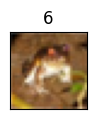

In [5]:
# Plot the first image (a frog) and set the corresponding label as title

import matplotlib.pyplot as plt
fig=plt.figure()
fig.set_size_inches(1,1)
p=fig.add_subplot()

p.set_title(str(label0))
p.axes.get_xaxis().set_visible(False)
p.axes.get_yaxis().set_visible(False)
plt.imshow(img0)

In this notebook we will use a less "conventional" way of accessing the data items.
- cifar10_train.data is an array of images so cifar10_train.data[0] is the first image
- cifar10_train.targets is an array of the corresponding labels so cifar10_train.targets[0] is the first label.

Next we create torch **tensors** from the datasets. For now, we think of a torch **tensor** as a multidimensional array.


**Note**: the pixel values are divided by the maximal value (255). This is ofen the case to aid with the convergence

In [6]:
img_train=torch.tensor(cifar10_train.data,dtype=torch.float32)/255.
img_test=torch.tensor(cifar10_test.data,dtype=torch.float32)/255.
label_train=torch.tensor(cifar10_train.targets,dtype=torch.float32)
label_test=torch.tensor(cifar10_test.targets,dtype=torch.float32)



## Logistic Regression

In this notebook we introduce Logistic Regression which can be regarded as the **simplest neural network**, a single "neuron". This type of network is sometime called a Perceptron, but the method used for learning is different from the way a Perceptron learns.



As can be seen from the figure in the next slide the input is a vector of size _n_ and it feeds a single unit (a neuron or perceptron). To obtain the output we perform the **dot** product between the matrix **W** and the input **x** and the result is fed into some function (usually nonlinear) _f_

$$
\begin{align*}
z&=\sum_iw_i\cdot x_i+b\\
\hat{y}(x)&=f(z)
\end{align*}
$$

Since $z$ depends on $w$ and $b$ so does $\hat{y}$. The input and _f_ are known whereas _W_ and _b_ are parameters to be determined. Our goal is to find the _optimal_ _W_ and _b_ such that the output is as *close as possible* to the label associated with the input.
![title](https://github.com/hikmatfarhat-ndu/CSC645/blob/master/figures/perceptron.png?raw=1)



How is **as close as possible** defined? The dataset is usually a set of pairs $(x,y)$. We define the loss as the **deviation** between the label $y$ and the result $\hat{y}=f(z)$

$$loss=E_{w,b}(y,\hat{y})$$

The function $E$ depends on the problem (for example binary cross entropy, mean squared error,...)

Note that $E$ depends on the parameters $w,b$. Our goal is to find the **optimal** $w,b$ such that the loss is minimal. From calculus we know that to find the minimum (max) of a function we compute its derivative and find where it is null.

## Sigmoid

So far we have not specified the function _f_ that our  model depends on $\hat{y}=f(z)$. In this example we use the **sigmoid** function. Given an input _z_ it has the form

$$
\begin{align*}
\sigma=\frac{1}{1+e^{-z}}
\end{align*}
$$

We can plot the sigmoid function using matplotlib. As you can see below the values of $\sigma$ go from 0 to 1 which we interpret as a probability. For example, if $\sigma=0.65$ then the probability of the image being a **ship** is 0.65 and of **not** being one is 0.35 so decide it is a ship.


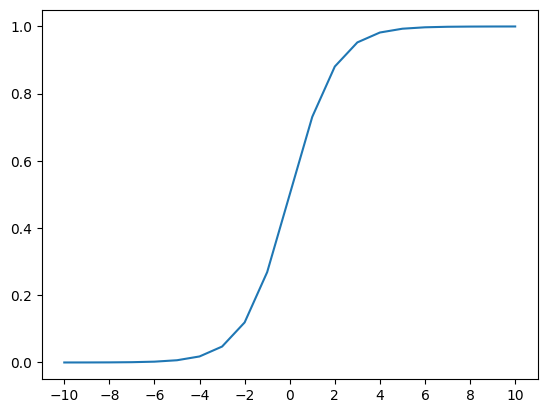

In [7]:
import numpy as np
z=[1/(1+np.exp(-x)) for x in range(-10,11)]
plt.plot([x for x in range(-10,11)],z)
plt.xticks([t for t in range(-10,11,2)])
plt.show()

## Gradient Descent

Now that we have an expression to optimize we need a method to find the optimal parameters. Typically, one computes the __gradient__ and the optimal value corresponds to the value  of the parameters when the __gradient vanishes__. Unfortunately, for logistic regression there is __no closed form solution__ so we seek a numerical method to find the optimal parameters.



Our goal is to find the **optimal** values for _W_ and _b_. To do so we give them some _arbitrary_ values and then using the expression for $E$
In the figure below we show an arbitrary function _E(w)_. For a given value of _w_ we compute the derivative (slope) of _E_ with respect to _w_ (two different values are shown). The point on the left side has a negative slope so we need to **increase** the value of _w_ to move toward the minimum whereas the point on the right side the slope is positive so we have to **decrease** the value of _w_.




<center>
<img src="https://github.com/hikmatfarhat-ndu/CSC645/blob/master/figures/gradient-descent.png?raw=1" width="350">
</center>


If slope is negative, increase the value of 'w'
If slope is positive, decrease the value of 'w'

In general we "update" the values of _w_ and _b_ as follows

$$
\begin{align*}
  w=w-\alpha\cdot \frac{\partial E}{\partial w}\\
  b=b-\alpha\cdot \frac{\partial E}{\partial b}
\end{align*}
$$

where $\alpha$ is a parameter chosen by us, called the __learning rate__.

## Flatening the images
The images have dimensions (3,32,32) (3 channels, 32 height,32 width). To feed them to our "neuron" we need to create a vector of dimension 3x32x32

In [8]:
img_train.shape

torch.Size([50000, 32, 32, 3])

In [9]:
dim=3*32*32
train_samples=50000
test_samples=10000
img_train=img_train.reshape(train_samples,dim)
img_test=img_test.reshape(test_samples,dim)

As mentioned before, to simplify the problem, we group all inanimate entities together by giving them the label 1 and all animate things together by giving them the label 0

In [10]:
img_train.shape

torch.Size([50000, 3072])

In [11]:
#airplane=0,car=1,bird=2,cat=3,deer=4,dog=5,frog=6,horse=7,ship=8,truck=9
features=torch.tensor([0,1,8,9]) # These are inanimate objects
for i in range(label_train.shape[0]):
    if torch.isin(label_train[i],features):
        label_train[i]=1
    else:
        label_train[i]=0

for i in range(label_test.shape[0]):
    if torch.isin(label_test[i],features):
        label_test[i]=1
    else:
        label_test[i]=0

In [13]:
# the dataset is a bit biased
torch.count_nonzero(label_train) # 20,000 inanimate objects

tensor(20000)

## Initialize the parameters
Our goal is to find the **optimal** values for the parameters, weights and bias. Intially we give them random values (for weights) and 0 for the bias as shown below. Note two things
1. We divide the initial values of the weights by the total number of samples to minimize the possibility of divergence.
1. The `reguires_grad` declares a tensor to be a variable, i.e. we need the derivative. In previous versions of Pytorch one needed to declare variables explicitly but this is deprecated now. See [here](https://pytorch.org/docs/stable/autograd.html#variable-deprecated)

In [14]:
weights=torch.rand(dim,requires_grad=True,dtype=torch.float32)
weights.data/=train_samples
bias=torch.tensor(0.,requires_grad=True,dtype=torch.float32)

## Optimization loop

In [17]:
# Learning Rate
rate=0.015
# For 0-1 classification we use the binary cross entropy (BCE) loss
loss_fn=torch.nn.BCELoss()

for i in range(1000):
  y_hat=torch.matmul(img_train,weights)+bias
  y_hat=torch.sigmoid(y_hat) # This gives us the probability
  loss=loss_fn(y_hat.squeeze(),label_train)
  # Compute the gradient wrt weights and bias
  dw,db=torch.autograd.grad(loss,[weights,bias])
  # Update the weights and bias
  weights.data-=rate*dw
  bias.data-=rate*db

  if(i%100==0):
    print("loss {:.4f}".format(loss.item()))

loss 0.4342
loss 0.4331
loss 0.4322
loss 0.4313
loss 0.4304
loss 0.4297
loss 0.4290
loss 0.4283
loss 0.4277
loss 0.4272


## Prediction on the test data

An important measure of any ML method is how well it "generalizes". This is done by using the trained model on test data, i.e. other than the data it was trained on. To do that we note that the output of our model is the probability that the input is an inanimate object, which could be any value between 0 and 1. The test labels are discrete values of 0 and 1 so how do we compare them? We regard a probability $\ge 0.5$ to be 1 and $< 0.5$ to be 0

In [18]:
def predict(X):
    # m is the number of samples
    m = X.size()[0]
    # initialize the prediction variable
    label_prediction = torch.zeros(m,1)

    # Compute vector "y_hat" predicting
    # the probabilities of a machine being present in the picture

    y_hat=torch.matmul(X,weights)+bias
    y_hat=torch.sigmoid(y_hat)
    # loop over all samples
    for i in range(y_hat.size()[0]):
        # Convert probabilities y_hat[0,i] to actual predictions
        #if y_hat[i]>=0.5:
        if y_hat[i]>=0.5:
            label_prediction[i]=1 # If probability >= 0.5, it is inanimate
        else:
            label_prediction[i]=0 # Otherwise, it is animate


    return label_prediction

In [19]:
label_prediction_test = predict(img_test).squeeze()
label_prediction_train = predict(img_train).squeeze()
print("train accuracy:"+str((100 - torch.mean(torch.abs(label_prediction_train - label_train)) * 100)))
print("test accuracy:"+str((100 - torch.mean(torch.abs(label_prediction_test - label_test)) * 100)))

train accuracy:tensor(81.9040)
test accuracy:tensor(81.6200)


## Using Pytorch

The model used in this notebooks is simple enough to code directly. We only needed Pytorch to compute the gradients. When more complicated models are used this process becomes unwieldy. We can use Pytorch to abstract away the details.  
The abstractions offered by Pytorch are illustrated below to solve the same problem that we just did. In later notebooks,  the training procedure is more or less the same, only the model and the optimizer will differ.

### The model

The model we plan to use is encapsulated in a class that **inherits** from ```torch.nn.Module```

All we need to do is **override** two methods:
1. ```__init__```. As you would have guess this is called when the object is constructed to initialize our model
1. ``` forward```. This is called everytime a forward computation is needed

In [20]:
import torch.nn as nn

class Net(nn.Module):
  def __init__(self,in_features,out_features):
    super(Net, self).__init__()
    self.input_size=in_features
    self.output_size=out_features
    # declaring weights and bias as parameters so that they are included
    # in the return value of .parameters()
    self.weights=nn.Parameter(torch.rand(in_features,requires_grad=True,dtype=torch.float32))
    self.weights.data/=in_features
    self.bias=nn.Parameter(torch.tensor(0.,requires_grad=True,dtype=torch.float32))
    #self.layer=nn.Linear(self.input_size,self.output_size,bias=True)
  def forward(self,input):
    y_hat=torch.matmul(input,self.weights)+self.bias # matmul = matrix multiply
    y_hat=torch.sigmoid(y_hat)
    return y_hat

Note that in the initialization, the weights and bias are constructed as ```Parameter```. This is so that we can use the ```.parameters()``` call and pass it to the optimizer.
Next we create an instance of the model

In [22]:
model=Net(dim,1) # dim=3*32*32

Recall that each learning iteration performs a number of steps.
- Compute the forward pass over the input to get the output. This is now done using ```model.forward()``` indirectly by calling ```model(input)```
- Compute the loss using an appropriate loss function. Same as before


- Compute the gradients. Now we use ```loss.backward()```. Not only it computes the gradient with respect to the parameters but saves those values in the parameters themselves. For example, if ```p``` is a parameters then ```loss.backward()``` computes the gradient and saves it in ```p.grad```
- Update the parameters. This is done by the optimizer using ```optimizer.step()```. This is important since later on we will use optimizers that use a different strategy to update the parameters.

In [ ]:
rate=0.015

import torch.optim as optim
optimizer=optim.SGD(model.parameters(),lr=rate) # The parameters are the weight and the bias
loss_fn=torch.nn.BCELoss()

for i in range(1000):
  # uses the .forward() method to get y_hat
  y_hat=model(img_train) # => model.forward(img_train)
  # as before
  loss=loss_fn(y_hat.squeeze(),label_train)
  # Computes the gradients and saves them in the appropriate .grad
  # Uses back propagation to compute the gradient
  loss.backward() ## suppose dloss/dw = x   then W.grad += x
  # updates the parameters using the computed .grad
  optimizer.step() ## W -= alpha . W.grad
  # zero the .grad values so that they don't accumulate
  optimizer.zero_grad()
  if(i%100==0):
    print("loss {:.4f}".format(loss.item()))